In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

## Load Data

In [10]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/20220628/atlas_mm_vmm_bkgr_1_TEST/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [11]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 200000/200000 [00:07<00:00, 27031.44it/s]

!!
I read 200000 events, of which 100000 have muon and 100000 do not
!!


In [12]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

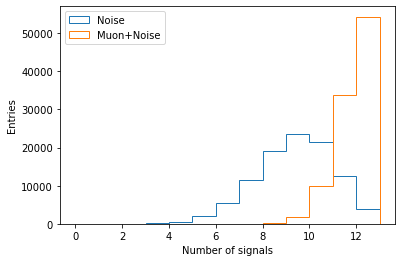

In [13]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], histtype='step', range=(0,13), bins=13, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], histtype='step', range=(0,13), bins=13, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

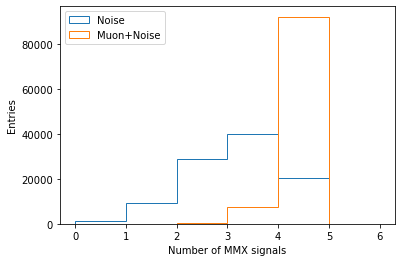

In [14]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

## Define models to compare

In [15]:
%ls -lhrt ../models/

total 136K
drwxr-sr-x 4 rafaeltl at 8.0K Jun 28 08:08 gru_BatchNormTrue_MaskingFalse_28062022_06.21.52/
drwxr-sr-x 4 rafaeltl at 4.0K Jun 28 11:22 lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/
drwxr-sr-x 4 rafaeltl at 4.0K Jun 28 23:35 gru_BatchNormFalse_MaskingFalse_28062022_06.00.14/
drwxr-sr-x 4 rafaeltl at 8.0K Jun 29 01:18 lstm_BatchNormFalse_MaskingFalse_29062022_00.09.58/
drwxr-sr-x 4 rafaeltl at 8.0K Jun 29 02:21 gru_BatchNormFalse_MaskingFalse_29062022_01.20.50/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  4 09:32 lstm_BatchNormFalse_MaskingFalse_04072022_09.00.14/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  4 10:12 lstm_BatchNormFalse_MaskingFalse_04072022_09.44.46/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  5 05:29 mlp_BatchNormFalse_MaskingFalse_05072022_05.27.55/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  5 06:08 tcn_BatchNormFalse_MaskingFalse_05072022_05.56.33_detMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  5 08:37 lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/
drwxr-sr-x 4 rafaeltl at 8

In [71]:
mdict = {
    "TCN-pad-reg":{
        "loc": "tcn_BatchNormFalse_MaskingFalse_regression1_20072022_07.19.21_normalMatrix",
        "data_det": False,
        "data_card": "../../cards/atlas_mm_vmm.yml",
        "data_flat": False,
        "color": "C2",
        "x_reg_out": 1
    }
}

In [72]:
import trainingvariables

In [73]:
for mod in mdict:
    
    if 'yhat' in mdict[mod].keys():
        print("Already added this model")
        continue
    
    if mdict[mod]['data_det']:
        X_prep = datatools.detector_matrix(dmat, sig_keys, mdict[mod]['data_card'])
    else:
        X_prep = datatools.training_prep(dmat, sig_keys)
        
    
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    X = X_prep[:,:,vars_of_interest]
    
    if mdict[mod]['data_flat']:
        X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    model_loc = '../models/'
    
    model = keras.models.load_model(model_loc+mdict[mod]['loc'],compile=False)
    
    preds = model.predict(X, batch_size=1024)
    
    mdict[mod]['yhat'] = preds[:,0]
    
    mult_fact = max(data['ev_mu_x'])
    
    if 'x_reg_out' in mdict[mod]:
        mdict[mod]['x_reg'] = preds[:,mdict[mod]['x_reg_out']]*mult_fact
        
    if 'a_reg_out' in mdict[mod]:
        mdict[mod]['a_reg'] = preds[:,mdict[mod]['a_reg_out']]

~~ Preparing padded matrix ~~
Data already prepared?


100%|██████████| 200000/200000 [00:07<00:00, 25470.03it/s]


Output data matrix shape: (200000, 12, 19)


In [74]:
import linefit

In [75]:
lfits = linefit.get_fits(dmat, sig_keys)

/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/21062022/si-mu-lator/algorithms/notebooks/../linefit.py:25: RuntimeWarning: invalid value encountered in double_scalars
  A = ( _c5*_c2 - _c3*_c4 ) / ( _c2**2 - _c1*_c4 )
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/21062022/si-mu-lator/algorithms/notebooks/../linefit.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  A = ( _c5*_c2 - _c3*_c4 ) / ( _c2**2 - _c1*_c4 )
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/21062022/si-mu-lator/algorithms/notebooks/../linefit.py:29: RuntimeWarning: invalid value encountered in add
  Chi2 = ( ( A*zs + B - xs )**2 / unc_xs**2 ).sum()


## Make plots

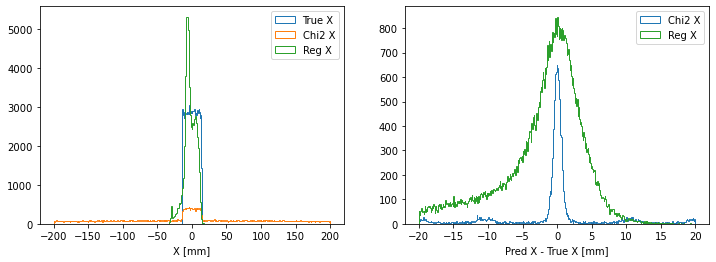

In [76]:
ncols, nrows = (2,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

for mod in mdict:
    
    this_cut=(Y_mu==1)
    
    
    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-200,200),
                bins=500, label=f'True X')
    
    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-200,200),
                bins=500, label=f'Chi2 X')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-20,20),
                bins=500, label=f'Chi2 X')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-200,200), bins=500, color=mdict[mod]['color'], 
                    label=f'Reg X')
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-20,20), bins=500, color=mdict[mod]['color'], 
                    label=f'Reg X')
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[0].legend()
    axs[1].legend()
plt.show()

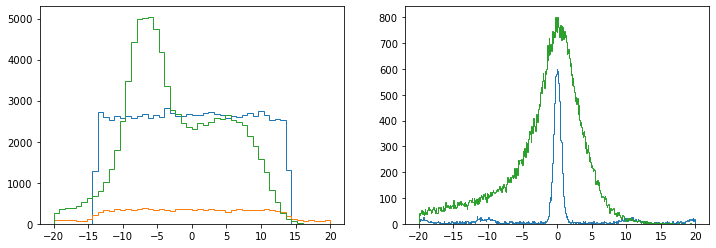

In [77]:
ncols, nrows = (2,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

for mod in mdict:
    
    this_cut=(Y_mu==1)*(data['n_sig_mmx']>3)
    
    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-20,20),
                bins=50, label=f'True X')
    
    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-20,20),
                bins=50, label=f'Chi2 X')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-20,20),
                bins=500, label=f'Chi2 X')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-20,20), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Signal')
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
                    histtype='step', range=(-20,20), bins=500, color=mdict[mod]['color'], 
                    label=f'[{mod}] Background')
        
plt.show()

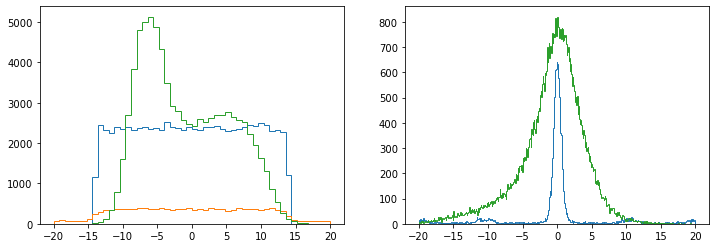

In [78]:
ncols, nrows = (2,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

for mod in mdict:
    
    this_cut=(Y_mu==1)*(mdict[mod]['yhat']>0.9)
    
    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-20,20),
                bins=50, label=f'True X')
    
    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-20,20),
                bins=50, label=f'Chi2 X')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-20,20),
                bins=500, label=f'Chi2 X')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-20,20), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Signal')
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
                    histtype='step', range=(-20,20), bins=500, color=mdict[mod]['color'], 
                    label=f'[{mod}] Background')
        
plt.show()

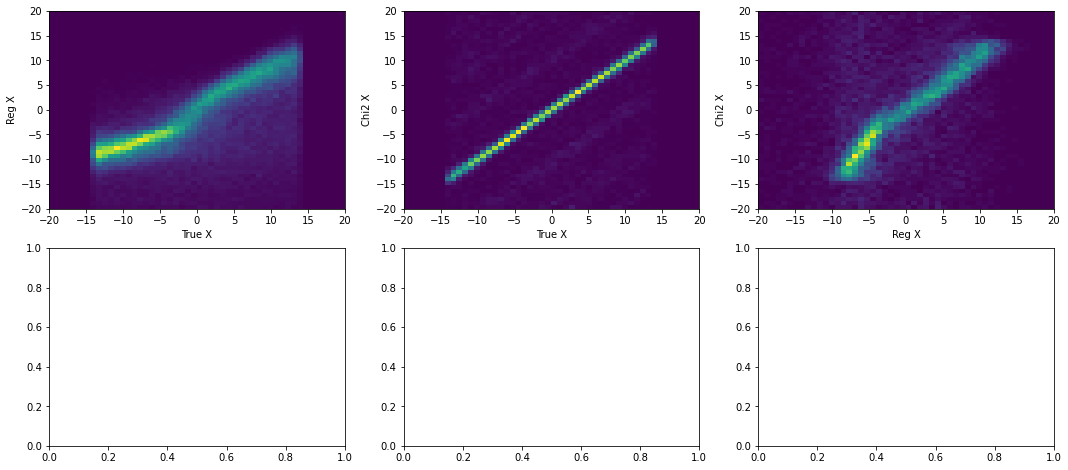

In [79]:
ncols, nrows = (3,2)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

for mod in mdict:

    
    this_cut=(Y_mu==1)
    
    axs[0].hist2d( data['ev_mu_x'][this_cut], 
                   mdict[mod]['x_reg'][this_cut], 
                  range=((-20,20),(-20,20)),
                bins=(50,50))
    axs[0].set_xlabel('True X')
    axs[0].set_ylabel('Reg X')
    
    axs[1].hist2d( data['ev_mu_x'][this_cut], 
                   lfits[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50))
    axs[1].set_xlabel('True X')
    axs[1].set_ylabel('Chi2 X')
    
    axs[2].hist2d( mdict[mod]['x_reg'][this_cut], 
                   lfits[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50))
    axs[2].set_xlabel('Reg X')
    axs[2].set_ylabel('Chi2 X')
    
#     axs[3].hist2d( data['ev_mu_x'][this_cut], 
#                    mdict[mod]['yhat'][this_cut], 
#                   range=((-20,20),(0.95,1)),
#                 bins=(50,50))
    
#     axs[4].hist2d(mdict[mod]['x_reg'][this_cut], 
#                   mdict[mod]['yhat'][this_cut], 
#                   range=((-20,20),(0.95,1)),
#                 bins=(50,50) )
    
        
plt.show()